In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [8]:
data_path = 'genome.csv'
data = pd.read_csv(data_path)

# Preview the data
data.head()

# Check the structure of the dataset
data.info()

print(data.describe())

C:\Users\JERON\AppData\Local\Temp\ipykernel_12960\2904457491.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966977 entries, 0 to 966976
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   rsid        966977 non-null  object
 1   chromosome  966977 non-null  object
 2   position    966977 non-null  int64 
 3   genotype    966977 non-null  object
dtypes: int64(1), object(3)
memory usage: 29.5+ MB
           position
count  9.669770e+05
mean   7.672147e+07
std    5.640974e+07
min    3.000000e+00
25%    3.012131e+07
50%    6.667251e+07
75%    1.134776e+08
max    2.471856e+08


## Data Exploration

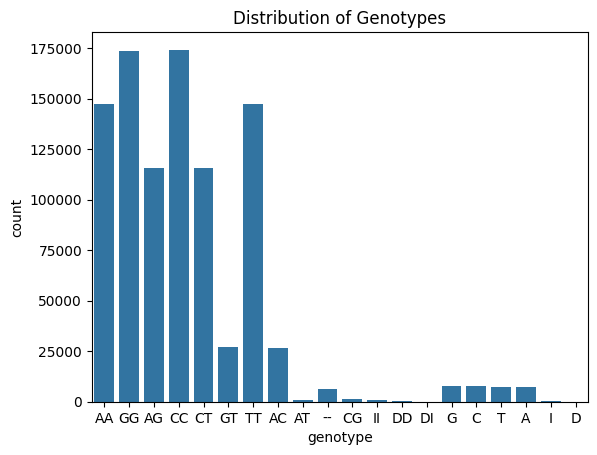

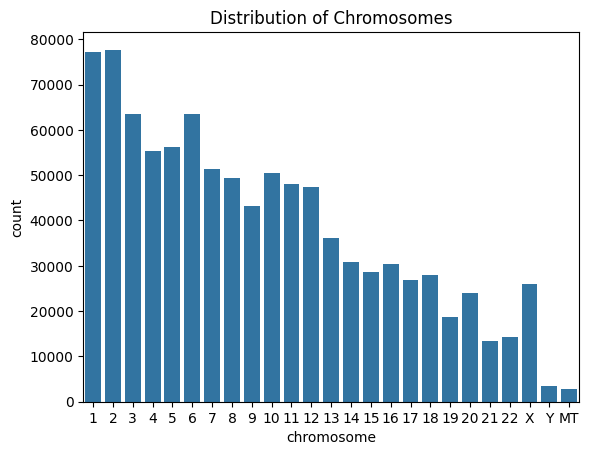

In [9]:
import seaborn as sns

# Count plot for genotypes
sns.countplot(x='genotype', data=data)
plt.title('Distribution of Genotypes')
plt.show()

# Count plot for chromosome
sns.countplot(x='chromosome', data=data)
plt.title('Distribution of Chromosomes')
plt.show()

## Data Preprocesing

## Apply Kmeans Clustering